# Análisis Exploratorio de Rendimiento en la Liga Inglesa 2017–2018

**Consultor:** Julián Camilo Ramos Granada 

**Entrega para:** Dirección de Estrategia Deportiva – Proyecto de Expansión Liga Inglesa  

**Fecha:** Septiembre de 2025  

---

## Presentación del Documento

Este informe es entregado como parte del trabajo de consultoría solicitado por una compañía interesada en formar un nuevo equipo de fútbol en la liga inglesa. El objetivo general es realizar un análisis exploratorio de los resultados, estadísticas de equipos y desempeño individual de los jugadores durante la temporada 2017–2018, con el propósito de extraer hallazgos que sirvan como estrategia para la toma de decisiones en procesos de selección, formación y estilo de juego del nuevo equipo.


Para ello, se utilizaron técnicas de análisis de datos de alto volumen, haciendo uso de herramientas como Apache Spark y sistemas distribuidos de almacenamiento (HDFS), que permiten el procesamiento eficiente de grandes cantidades de información. La exploración se realizará sobre tres conjuntos de datos fundamentales: resultados de los partidos, estadísticas por equipo y rendimiento individual de los jugadores.



# Contexto, Objetivos y Metodología

## Contexto del Negocio

Una compañía del sector deportivo se encuentra en proceso de planeación estratégica para la creación de un nuevo equipo de fútbol con participación en la liga inglesa. Como parte de su fase inicial, la organización ha solicitado un análisis técnico y descriptivo de la temporada 2017–2018, con el fin de comprender los factores que determinaron el desempeño de los equipos participantes, así como las características individuales de los jugadores con mejor rendimiento.

Este análisis busca servir como punto de partida para definir el tipo de juego que se desea adoptar, el perfil de los jugadores que se deberían contratar, y los aspectos clave que contribuyen a un rendimiento competitivo y sostenible en la liga. La exploración de estos datos permitirá sustentar decisiones estratégicas tanto en la conformación de la plantilla como en el enfoque táctico general del equipo.

---

## Objetivo del Análisis

El propósito principal de este análisis es identificar patrones de desempeño y características destacables tanto a nivel colectivo (equipos) como individual (jugadores) que puedan orientar a la compañía en la conformación de su nuevo equipo.

De forma más específica, se pretende:

- Analizar los resultados y estadísticas de los partidos disputados durante la temporada 2017–2018.
- Comprender el impacto de variables como goles, posesión, disparos, y otras métricas clave en el desempeño de los equipos.
- Identificar jugadores con indicadores de rendimiento sobresalientes o consistentes.

---

## Metodología Adoptada

Para alcanzar los objetivos anteriores, se desarrolló una estrategia de análisis estructurada en las siguientes fases:

1. **Carga de datos desde HDFS:** Lectura de tres conjuntos de datos en formatos `.csv` y `.json` utilizando PySpark como motor de procesamiento distribuido.
2. **Exploración y comprensión de variables:** Revisión detallada de los atributos de cada dataset, destacando los más relevantes para el problema de negocio.
3. **Análisis de calidad de datos:** Validación de la integridad, completitud y consistencia de los datos.
4. **Estadísticas descriptivas:** Cálculo de métricas como medias, máximos, distribuciones y rangos para comprender la variabilidad de las variables seleccionadas.
5. **Visualización de resultados:** Generación de gráficos para apoyar la interpretación visual de los datos.
6. **Conclusiones y recomendaciones:** Redacción de sugerencias claras para la empresa contratante con base en la evidencia recopilada.

Cada sección de este cuaderno seguirá esta estructura metodológica, desarrollando el análisis de forma ordenada y documentada.


#   Inicialización del Entorno de Procesamiento

Antes de iniciar con el análisis exploratorio, es necesario configurar correctamente el entorno de trabajo para asegurar el procesamiento eficiente de los datos almacenados en el sistema distribuido (HDFS). Dado que se trata de un proyecto que trabaja con volúmenes considerables de información estructurada en múltiples archivos, se emplea **Apache Spark**, un motor de procesamiento paralelo diseñado para análisis de alto rendimiento.



In [1]:
# Creación de sesión en el Clúster HPC

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count, when, isnull, mean, stddev, min, max

# Configuración para Premier League 17/18
configura = SparkConf().set("spark.scheduler.mode", "FAIR")
configura.setAppName("PremierLeague_1718_Analisis")

# Crear sesión de Spark
spark = SparkSession.builder.config(conf=configura).getOrCreate()

# Crear contexto SQL
sqlContext = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)

# Obtener contexto de Spark
contexto = spark.sparkContext

# Confirmación
print("Sesión Spark iniciada para análisis Premier League 17/18")
print(f"Versión Spark: {spark.version}")
print(f"Nombre aplicación: {spark.conf.get('spark.app.name')}")
print(f"Scheduler mode: {spark.conf.get('spark.scheduler.mode')}")
print(f"Master: {contexto.master}")
print(f"Application ID: {contexto.applicationId}")

# objeto de sesión
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/08 19:32:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/08 19:32:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/09/08 19:32:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/09/08 19:32:02 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


Sesión Spark iniciada para análisis Premier League 17/18
Versión Spark: 3.5.5
Nombre aplicación: PremierLeague_1718_Analisis
Scheduler mode: FAIR
Master: spark://10.195.34.34:7077
Application ID: app-20250908193202-0008


# 4. Exploración y calidad de los datos

Antes de iniciar cualquier tipo de análisis cuantitativo o visual, es necesario comprender la estructura contenido y calidad de los datos disponibles. En esta sección se realizaró una revisión detallada de los tres conjuntos de datos suministrados, los cuales contienen información relacionada con la temporada 2017–2018 de la Premier League.

Los tres datasets que serán explorados son:

- `resultados_futbol.csv`: contiene los resultados detallados de cada partido disputado durante la temporada.
- `jugadores.csv`: presenta estadísticas individuales por jugador.
- `temporadas.json`: agrupa estadísticas generales por equipo durante la misma temporada.

Cada uno de estos archivos será tratado por separado en su propia subsección. El propósito es garantizar una comprensión clara y profunda de sus variables, identificar posibles problemas de calidad (valores nulos, inconsistencias, duplicados, entre otros), y preparar los datos para su posterior análisis.

Durante la exploración se realizará:

- La carga del conjunto de datos desde el sistema de archivos distribuido (HDFS).
- La revisión del esquema y tipos de datos inferidos por Spark.
- La visualización preliminar de los registros.
- El conteo de registros y columnas.
- La verificación de valores faltantes y posibles inconsistencias.
  



## 4.1 Exploración y calidad de datos: resultados_futbol.csv

El primer conjunto de datos explorado corresponde al archivo `resultados_futbol.csv`, el cual contiene información detallada sobre los partidos disputados. Este dataset representa la base para entender el comportamiento de los equipos en función de sus resultados finales, estadísticas de juego y desempeño por jornada.

### Carga y estructura de los datos

El archivo fue cargado exitosamente desde el sistema de archivos distribuido (HDFS), detectando un total de 11,113 registros distribuidos en 23 columnas. Aunque el conjunto de datos no incluye documentación técnica explícita ni un diccionario de variables, fue posible inferir el significado de cada columna con base en estructuras de datos deportivos utilizados en repositorios públicos como Kaggle y las convenciones estandarizadas en datasets históricos de la liga.



A continuación se presenta el esquema general de columnas junto con su interpretación:

- `Season` (string): temporada a la que corresponde el partido.
- `DateTime` (timestamp): fecha y hora en que se disputó el encuentro.
- `HomeTeam` / `AwayTeam` (string): nombres del equipo local y visitante.
- `FTHG` / `FTAG` (integer): goles marcados por el equipo local y visitante al finalizar el partido.
- `FTR` (string): resultado final del partido (H: gana local, D: empate, A: gana visitante).
- `HTHG` / `HTAG` / `HTR` (string): goles al medio tiempo del local y visitante, y resultado parcial del partido.
- `Referee` (string): árbitro asignado al encuentro.

El resto de las columnas corresponden a estadísticas de desempeño por equipo. Cada métrica tiene su variante para el equipo local (`H`) y para el visitante (`A`):

- `HS` / `AS` (string): disparos totales.
- `HST` / `AST` (string): disparos al arco.
- `HC` / `AC` (string): tiros de esquina.
- `HF` / `AF` (string): faltas cometidas.
- `HY` / `AY` (string): tarjetas amarillas.
- `HR` / `AR` (string): tarjetas rojas.



Se encontró que si bien algunas variables deberían ser de tipo numérico (por ejemplo, `HS`, `HST`, `HC`, etc.), fueron inferidas como cadenas de texto (`string`) por Spark. Esto se debe a la presencia de valores no numéricos en algunas celdas, como "NA". Esta situación fue considerada durante la fase de limpieza.

### Vista preliminar de los datos

La inspección de las primeras filas muestra registros correspondientes a la temporada 1993–1994, incluyendo los nombres de los equipos, los goles marcados y el resultado final del encuentro. Sin embargo, se observa que la mayoría de las variables estadísticas (disparos, tarjetas, faltas, etc.) presentan valores "NA" para esas temporadas iniciales, lo que indica una ausencia de recolección de datos en años anteriores.

### Calidad de los datos

La revisión de valores nulos muestra que todas las columnas fueron cargadas sin valores nulos explícitos (`null`), ya que las celdas vacías fueron representadas como cadenas "NA", haciendo que se interpreten como valores válidos. No obstante, estas cadenas deben ser tratadas como datos faltantes en el proceso de limpieza, ya que afectan directamente la capacidad de análisis cuantitativo.

En cuanto a la duplicidad, se confirmó que el conjunto de datos no contiene registros repetidos.


In [23]:
# 4.1 Exploración y calidad de datos: resultados_futbol.csv

# Ruta del archivo en HDFS
ruta_resultados = "hdfs://10.195.34.34:9000/csv/resultados_futbol.csv"

# Carga del archivo como DataFrame
resultados_df = spark.read.csv(ruta_resultados, header=True, inferSchema=True)

# Revisión del esquema de columnas y tipos inferidos
print("Esquema del DataFrame:")
resultados_df.printSchema()

# Visualización de las primeras filas del dataset
print("\nPrimeras filas del dataset:")
resultados_df.show(5, truncate=False)

# Conteo de registros y columnas
num_filas = resultados_df.count()
num_columnas = len(resultados_df.columns)
print(f"\nNúmero total de filas: {num_filas:,}")
print(f"Número total de columnas: {num_columnas}")

# Lista de columnas disponibles
print("\nColumnas del dataset:")
for nombre_col in resultados_df.columns:
    print(f" - {nombre_col}")

# Revisión de valores nulos por columna
print("\nConteo de valores nulos por columna:")
resultados_df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in resultados_df.columns
]).show()

# Verificación de duplicados
print("\nNúmero de registros duplicados:")
duplicados = resultados_df.count() - resultados_df.dropDuplicates().count()
print(f"Registros duplicados encontrados: {duplicados}")


Esquema del DataFrame:
root
 |-- Season: string (nullable = true)
 |-- DateTime: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTHG: integer (nullable = true)
 |-- FTAG: integer (nullable = true)
 |-- FTR: string (nullable = true)
 |-- HTHG: string (nullable = true)
 |-- HTAG: string (nullable = true)
 |-- HTR: string (nullable = true)
 |-- Referee: string (nullable = true)
 |-- HS: string (nullable = true)
 |-- AS: string (nullable = true)
 |-- HST: string (nullable = true)
 |-- AST: string (nullable = true)
 |-- HC: string (nullable = true)
 |-- AC: string (nullable = true)
 |-- HF: string (nullable = true)
 |-- AF: string (nullable = true)
 |-- HY: string (nullable = true)
 |-- AY: string (nullable = true)
 |-- HR: string (nullable = true)
 |-- AR: string (nullable = true)


Primeras filas del dataset:
+-------+-------------------+-----------+--------------+----+----+---+----+----+---+-------+---+---+---+---+---+---+

### Limpieza de datos

Durante la revisión inicial, se identificó que múltiples columnas que deberían ser de tipo numérico fueron interpretadas como cadenas de texto debido a la presencia del valor "NA.

Para corregir esto, se realizó un proceso de limpieza:

1. Reemplazo de todos los valores "NA" por valores nulos (null).
2. Conversión de las columnas afectadas al tipo Integer, con el propósito de poder realizar cálculos estadísticos.

Una vez aplicada la limpieza, se verificó que el esquema del DataFrame reflejara correctamente los tipos de datos. Además, se contabilizaron los valores no nulos por columna para entender la disponibilidad de información por variable. Los resultados mostraron que:

- Las columnas de goles al medio tiempo (HTHG, HTAG) tienen cobertura en aproximadamente el 92% de los registros.
- Las columnas de estadísticas de juego (disparos, tarjetas, faltas) están presentes en alrededor del 75% de los registros, lo cual puede significar que algunas temporadas más antiguas no cuentan con esta información.



In [24]:
# LIMPIEZA DE DATOS: resultados_futbol.csv

from pyspark.sql.types import IntegerType

# 1. Lista de columnas que deberían ser numéricas pero están como string
columnas_a_convertir = [
    'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST',
    'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR'
]

# Reemplazo de valores "NA" por nulls (None en PySpark)
for col_name in columnas_a_convertir:
    resultados_df = resultados_df.withColumn(
        col_name,
        F.when(F.col(col_name) == "NA", None).otherwise(F.col(col_name))
    )

# Conversión de columnas a tipo Integer
for col_name in columnas_a_convertir:
    resultados_df = resultados_df.withColumn(col_name, F.col(col_name).cast(IntegerType()))

# Verificación del esquema actualizado
print("Esquema actualizado del DataFrame:")
resultados_df.printSchema()

# Verificación del número de registros válidos (no nulos) por cada columna convertida
print("Conteo de valores no nulos por columna numérica:")
resultados_df.select([
    F.count(F.col(c)).alias(c) for c in columnas_a_convertir
]).show()


Esquema actualizado del DataFrame:
root
 |-- Season: string (nullable = true)
 |-- DateTime: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTHG: integer (nullable = true)
 |-- FTAG: integer (nullable = true)
 |-- FTR: string (nullable = true)
 |-- HTHG: integer (nullable = true)
 |-- HTAG: integer (nullable = true)
 |-- HTR: string (nullable = true)
 |-- Referee: string (nullable = true)
 |-- HS: integer (nullable = true)
 |-- AS: integer (nullable = true)
 |-- HST: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- HC: integer (nullable = true)
 |-- AC: integer (nullable = true)
 |-- HF: integer (nullable = true)
 |-- AF: integer (nullable = true)
 |-- HY: integer (nullable = true)
 |-- AY: integer (nullable = true)
 |-- HR: integer (nullable = true)
 |-- AR: integer (nullable = true)

Conteo de valores no nulos por columna numérica:
+-----+-----+----+----+----+----+----+----+----+----+----+----+----+--

## 4.2 Exploración y calidad de datos: jugadores.csv

El segundo conjunto de datos corresponde al archivo `jugadores.csv`, el cual contiene información individual sobre los jugadores activos en la temporada. Este dataset contiene variables clave relacionadas con el rendimiento, valor en el mercado, participación en el Fantasy Premier League (FPL), entre otras.

### Carga y estructura de los datos

El archivo fue cargado correctamente desde el sistema de archivos distribuido (HDFS), detectando un total de 461 registros y 17 columnas. A diferencia del conjunto anterior, este dataset cuenta con una estructura limpia, bien definida y sin ambigüedades evidentes en los nombres de las columnas.

A continuación se describe el significado de cada atributo inferido:

- `name` (string): nombre del jugador.
- `club` (string): equipo al que pertenece.
- `age` (integer): edad del jugador.
- `position` (string): posición detallada en el campo (por ejemplo: GK, LW, CB).
- `position_cat` (integer): categoría numérica general de posición (1: ofensiva, 2: media, 3: defensa, 4: arquero).
- `market_value` (double): valor de mercado del jugador (en millones de euros).
- `page_views` (integer): número de visitas a la página del jugador.
- `fpl_value` (double): valor del jugador en el Fantasy Premier League.
- `fpl_sel` (string): porcentaje de usuarios que lo seleccionaron en el Fantasy.
- `fpl_points` (integer): puntos totales obtenidos en la temporada dentro del FPL.
- `region` (string): región de origen del jugador codificada numéricamente.
- `nationality` (string): país de nacionalidad.
- `new_foreign` (integer): indicador binario de si es extranjero y recién llegado a la liga.
- `age_cat` (integer): categoría de edad.
- `club_id` (integer): identificador numérico del club.
- `big_club` (integer): indicador binario de si el jugador pertenece a un club considerado grande.
- `new_signing` (integer): indicador binario de si el jugador fue una nueva contratación esa temporada.


### Calidad de los datos

Los resultados de la revisión inicial muestran un conjunto de datos altamente limpio:

- No se detectaron valores nulos en ninguna de las columnas.
- No se encontraron registros duplicados.

Dicho esto, no fue necesario realizar ninguna operación de limpieza o transformación adicional. 


In [20]:
# 4.2 Exploración y calidad de datos: jugadores.csv

# Ruta del archivo en HDFS
ruta_jugadores = "hdfs://10.195.34.34:9000/csv/jugadores.csv"

# Carga del archivo como DataFrame
jugadores_df = spark.read.csv(ruta_jugadores, header=True, inferSchema=True)

# Revisión del esquema de columnas y tipos inferidos
print("Esquema del DataFrame:")
jugadores_df.printSchema()

# Visualización de las primeras filas del dataset
print("\nPrimeras filas del dataset:")
jugadores_df.show(10, truncate=False)

# Conteo de registros y columnas
num_filas = jugadores_df.count()
num_columnas = len(jugadores_df.columns)
print(f"\nNúmero total de filas: {num_filas:,}")
print(f"Número total de columnas: {num_columnas}")

# Lista de columnas disponibles
print("\nColumnas del dataset:")
for nombre_col in jugadores_df.columns:
    print(f" - {nombre_col}")

# Revisión de valores nulos por columna
print("\nConteo de valores nulos por columna:")
jugadores_df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in jugadores_df.columns
]).show()

# Verificación de duplicados
print("\nNúmero de registros duplicados:")
duplicados_jugadores = jugadores_df.count() - jugadores_df.dropDuplicates().count()
print(f"Registros duplicados encontrados: {duplicados_jugadores}")


Esquema del DataFrame:
root
 |-- name: string (nullable = true)
 |-- club: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- position: string (nullable = true)
 |-- position_cat: integer (nullable = true)
 |-- market_value: double (nullable = true)
 |-- page_views: integer (nullable = true)
 |-- fpl_value: double (nullable = true)
 |-- fpl_sel: string (nullable = true)
 |-- fpl_points: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- nationality: string (nullable = true)
 |-- new_foreign: integer (nullable = true)
 |-- age_cat: integer (nullable = true)
 |-- club_id: integer (nullable = true)
 |-- big_club: integer (nullable = true)
 |-- new_signing: integer (nullable = true)


Primeras filas del dataset:
+-----------------+-------+---+--------+------------+------------+----------+---------+-------+----------+------+--------------+-----------+-------+-------+--------+-----------+
|name             |club   |age|position|position_cat|market_value|page_

## 4.3 Exploración y calidad de datos: temporadas.json → JugadoresJSON.csv

El tercer conjunto de datos corresponde al archivo original `temporadas.json`, el cual fue convertido previamente a CSV (`JugadoresJSON.csv`) para facilitar su análisis. Este archivo contiene información estadística detallada del rendimiento individual de los jugadores por partido.

### Carga y estructura de los datos

Debido a dificultades técnicas con la lectura directa del archivo JSON desde HDFS, se optó por realizar una conversión local a formato CSV. Este proceso permitió la carga directa en Pandas y su posterior exploración sin errores de compatibilidad.

El archivo convertido fue cargado exitosamente, identificando un total de **13,675 registros** y **38 columnas**. Cada fila representa la participación de un jugador en un partido específico, incluyendo identificadores, posición, calificación, goles, asistencias, tarjetas y otras estadísticas ofensivas y defensivas.

A continuación se presentan algunas de las columnas más relevantes:

- `player_rating` (float): calificación del jugador en el partido.
- `goals` / `goal_assist` (float): estadísticas de rendimiento ofensivo.
- `yellow_card` / `red_card` (float): comportamiento disciplinario.
- `man_of_the_match` (float): indica si fue elegido como jugador del partido.
- `touches`, `passes`, `aerial_won`, `total_tackle`, etc.: métricas de participación.


### Vista preliminar de los datos

La inspección de las primeras filas confirma que los registros están correctamente estructurados y que las estadísticas aparecen organizadas por jugador y partido. Se observan valores numéricos válidos en muchas métricas, aunque también se identifican múltiples celdas con valores ausentes (`NaN`), especialmente en estadísticas poco comunes como penaltis fallados o salvadas de penalti.


### Calidad de los datos

En términos de calidad, se identificaron aspectos importantes:

- No se encontraron registros duplicados, lo cual indica una correcta unicidad en la estructura del dataset.
- Varias columnas presentan una **alta proporción de valores nulos**. Algunas de ellas como `penalty_save`, `att_pen_miss`, `own_goals` o `last_man_tackle` tienen más del 99% de valores faltantes, lo cual puede comprometer su utilidad analítica.
- Las métricas más comunes (calificación, goles, asistencias, toques) tienen mejor cobertura y serán candidatas a ser incluidas como variables clave.

### Próximos pasos

Aunque los tipos de datos fueron correctamente inferidos y no se detectaron cadenas "NA" como en otros archivos, se realizará una limpieza complementaria para eliminar columnas irrelevantes y verificar la completitud por variable. Esto se detallará en la siguiente sección junto con la selección de variables clave.


In [ ]:
#CONVERSIÓN DEL JSON A CSV
from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder.getOrCreate()

# Cargar el JSON desde HDFS
df_raw = spark.read.text("hdfs://10.195.34.34:9000/json/temporadas.json")
json_str = "\n".join([row.value for row in df_raw.collect()])

# Parsear manualmente con json
import json
data = json.loads(json_str)

# Transformar el JSON anidado como en tu código original
lista = []

for X in data:
    for Y in data[str(X)]:
        for Z in data[str(X)][str(Y)]['Player_stats']:
            dicc = {}

            player_details = data[str(X)][str(Y)]['Player_stats'][str(Z)]['player_details']
            player_stats = data[str(X)][str(Y)]['Player_stats'][str(Z)]['Match_stats']

            dicc.update(player_details)
            dicc.update(player_stats)

            dicc['match'] = X
            dicc['team'] = Y
            dicc['player_name'] = str(Z)

            lista.append(dicc)

# Convertir a pandas
df = pd.DataFrame(lista)

# Reordenar columnas
columnas_a_reordenar = ['match', 'team']
nuevas_columnas = columnas_a_reordenar + [col for col in df.columns if col not in columnas_a_reordenar]
df = df[nuevas_columnas]

# Guardar como CSV si quieres
df.to_csv("JugadoresJSON.csv", index=False)


In [16]:
import pandas as pd

# 1. Carga del archivo CSV
df_temporadas = pd.read_csv("JugadoresJSON.csv", encoding="utf-8")

# 2. Dimensiones del DataFrame
print(f"Registros: {df_temporadas.shape[0]:,}")
print(f"Columnas: {df_temporadas.shape[1]}")

# 3. Primeras filas
print("\nPrimeras filas del dataset:")
display(df_temporadas.head())

# 4. Nombres de columnas
print("\nColumnas disponibles:")
for col in df_temporadas.columns:
    print(f"- {col}")

# 5. Tipos de datos
print("\nTipos de datos:")
print(df_temporadas.dtypes)

# 6. Revisión de valores nulos
print("\nValores nulos por columna:")
print(df_temporadas.isnull().sum())

# 7. Detección de duplicados
duplicados = df_temporadas.duplicated().sum()
print(f"\nNúmero de registros duplicados: {duplicados}")


Registros: 13,675
Columnas: 38

Primeras filas del dataset:


,match,team,player_id,player_name,player_position_value,player_position_info,player_rating,good_high_claim,touches,saves,...,post_scoring_att,second_yellow,red_card,clearance_off_line,own_goals,last_man_tackle,att_pen_target,penalty_save,att_pen_miss,att_pen_post
0,1190418,166,131171,Jonas Lössl,1,GK,6.61,2.0,39.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1190418,166,109117,Terence Kongolo,2,DC,6.19,NaN,30.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1190418,166,101664,Chris Löwe,2,DL,5.96,NaN,38.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1190418,166,29026,Zanka,2,DC,6.65,NaN,44.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1190418,166,132360,Christopher Schindler,2,DC,6.58,NaN,46.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Columnas disponibles:
- match
- team
- player_id
- player_name
- player_position_value
- player_position_info
- player_rating
- good_high_claim
- touches
- saves
- total_pass
- formation_place
- accurate_pass
- aerial_won
- aerial_lost
- fouls
- total_scoring_att
- total_tackle
- won_contest
- penalty_conceded
- blocked_scoring_att
- man_of_the_match
- goals
- att_pen_goal
- goal_assist
- six_yard_block
- yellow_card
- error_lead_to_goal
- post_scoring_att
- second_yellow
- red_card
- clearance_off_line
- own_goals
- last_man_tackle
- att_pen_target
- penalty_save
- att_pen_miss
- att_pen_post

Tipos de datos:
match                      int64
team                       int64
player_id                  int64
player_name               object
player_position_value      int64
player_position_info      object
player_rating            float64
good_high_claim          float64
touches                  float64
saves                    float64
total_pass               float64
formation_place   

### Limpieza de datos

Durante la revisión inicial, se identificó que múltiples columnas que deberían ser de tipo numérico fueron interpretadas como cadenas de texto debido a la presencia del valor `"NA"` en el archivo original.

Para corregir esto, se realizó un proceso de limpieza:

1. Reemplazo de todos los valores `"NA"` por valores nulos (`NaN`).
2. Conversión de las columnas afectadas al tipo `float64`, con el propósito de poder realizar cálculos estadísticos.

Una vez aplicada la limpieza, se verificó que el esquema del DataFrame reflejara correctamente los tipos de datos. Además, se contabilizaron los valores no nulos por columna para entender la disponibilidad de información por variable. Los resultados mostraron que:

- Las columnas con buena cobertura de datos como `player_rating`, `touches`, `total_pass` y `accurate_pass` tienen más del 75% de los registros completos.
- Otras métricas clave como `aerial_won`, `fouls`, `total_tackle` y `goal_assist` presentan cobertura parcial.
- Algunas columnas poco frecuentes como `penalty_save`, `att_pen_post`, `own_goals` o `second_yellow` presentan datos en menos del 5% de los registros.

Este análisis sugiere que, si bien existe buena información para variables de rendimiento general, habrá que considerar las variables más escasas durante el análisis exploratorio y modelado posterior.


In [17]:
import pandas as pd
import numpy as np

# Lista de columnas que deberían ser numéricas
columnas_a_convertir = [
    'player_rating', 'good_high_claim', 'touches', 'saves', 'total_pass',
    'accurate_pass', 'aerial_won', 'aerial_lost', 'fouls',
    'total_scoring_att', 'total_tackle', 'won_contest', 'penalty_conceded',
    'blocked_scoring_att', 'man_of_the_match', 'goals', 'att_pen_goal',
    'goal_assist', 'six_yard_block', 'yellow_card', 'error_lead_to_goal',
    'post_scoring_att', 'second_yellow', 'red_card', 'clearance_off_line',
    'own_goals', 'last_man_tackle', 'att_pen_target', 'penalty_save',
    'att_pen_miss', 'att_pen_post'
]

# Reemplazo de valores "NA" por np.nan
df_temporadas.replace("NA", np.nan, inplace=True)

# Conversión de columnas a tipo float (más seguro en Pandas por la presencia de NaNs)
for col in columnas_a_convertir:
    df_temporadas[col] = pd.to_numeric(df_temporadas[col], errors='coerce')

# Verificación de tipos de datos actualizados
print("Esquema actualizado:")
print(df_temporadas.dtypes[columnas_a_convertir])

# Conteo de valores no nulos por columna convertida
print("\nValores no nulos por columna numérica:")
print(df_temporadas[columnas_a_convertir].notna().sum())


Esquema actualizado:
player_rating          float64
good_high_claim        float64
touches                float64
saves                  float64
total_pass             float64
accurate_pass          float64
aerial_won             float64
aerial_lost            float64
fouls                  float64
total_scoring_att      float64
total_tackle           float64
won_contest            float64
penalty_conceded       float64
blocked_scoring_att    float64
man_of_the_match       float64
goals                  float64
att_pen_goal           float64
goal_assist            float64
six_yard_block         float64
yellow_card            float64
error_lead_to_goal     float64
post_scoring_att       float64
second_yellow          float64
red_card               float64
clearance_off_line     float64
own_goals              float64
last_man_tackle        float64
att_pen_target         float64
penalty_save           float64
att_pen_miss           float64
att_pen_post           float64
dtype: object

Val

## 5. Análisis descriptivo

Para esta sección se seleccionaron seis variables clave combinadas entre los archivos `jugadores.csv`, `jugadores_json.csv` (originalmente en formato JSON) y `resultados_futbol.csv`. Estas variables fueron escogidas por su relevancia en la evaluación del rendimiento individual de los jugadores, el impacto mediático, y el desempeño colectivo de los equipos a lo largo de la temporada.

### 🔍 Variables seleccionadas

Las siguientes seis variables fueron elegidas considerando distintos enfoques del análisis deportivo, financiero y competitivo:

---

#### 📊 Rendimiento individual del jugador (fuente: `jugadores_json.csv`)

- **`player_rating`**: Representa la calificación numérica del rendimiento del jugador durante el partido. Es una medida objetiva basada en sus acciones en el campo.
- **`man_of_the_match`**: Indica si el jugador fue elegido como el mejor del partido (`1`) o no (`0`). Refleja un reconocimiento cualitativo al impacto general del jugador.

---

#### 💰 Valor y popularidad (fuente: `jugadores.csv`)

- **`market_value`**: Valor económico del jugador en el mercado. Es importante para evaluar su relevancia financiera en el equipo y el interés de fichajes.
- **`page_views`**: Número de visualizaciones o consultas del perfil del jugador. Representa su nivel de visibilidad, interés mediático o notoriedad.

---

#### ⚽ Desempeño colectivo (fuente: `resultados_futbol.csv`)

- **`total_goals`**: Suma de los goles anotados por ambos equipos en cada partido (`FTHG + FTAG`). Es un indicador global de la intensidad ofensiva del encuentro.
- **`FTR`**: Resultado final del partido (`H`: gana el local, `D`: empate, `A`: gana el visitante). Permite relacionar el desempeño ofensivo con el desenlace del encuentro.

---

Esta combinación busca un equilibrio entre tres perspectivas clave del análisis futbolístico:

- **Rendimiento individual**: Captura el aporte real del jugador en el campo (`player_rating`, `man_of_the_match`).
- **Impacto mediático y financiero**: Mide cómo es percibido el jugador fuera del campo (`market_value`, `page_views`).
- **Resultados y juego colectivo**: Evalúa cómo se traduce ese rendimiento en el marcador final (`total_goals`, `FTR`).

A continuación, se presentan los análisis estadísticos y visualizaciones correspondientes para estas variables.


In [25]:
from pyspark.sql.functions import expr

# === Estadísticas de jugadores.csv (Spark DataFrame) ===
print("==== Estadísticas: jugadores.csv ====")
jugadores_df.select("market_value", "page_views").describe().show(5, truncate=False)

# === Estadísticas de temporadas.json (Pandas DataFrame) ===
print("==== Estadísticas: temporadas.json (df_temporadas) ====")
print(df_temporadas[["player_rating", "man_of_the_match"]].describe())

# === Estadísticas de resultados_futbol.csv (Spark DataFrame) ===
# Crear columnas combinadas de goles y tiros al arco
resultados_df = resultados_df.withColumn("total_goals", expr("FTHG + FTAG")) \
                             .withColumn("total_shots_on_target", expr("HST + AST"))

print("==== Estadísticas: resultados_futbol.csv ====")
resultados_df.select("total_goals", "total_shots_on_target").describe().show(5, truncate=False)

print("==== Distribución de resultados (FTR): ====")
resultados_df.groupBy("FTR").count().show()


==== Estadísticas: jugadores.csv ====
+-------+------------------+-----------------+
|summary|market_value      |page_views       |
+-------+------------------+-----------------+
|count  |461               |461              |
|mean   |11.012039045553143|763.7765726681127|
|stddev |12.257402881461974|931.805757407049 |
|min    |0.05              |3                |
|max    |75.0              |7664             |
+-------+------------------+-----------------+

==== Estadísticas: temporadas.json (df_temporadas) ====
       player_rating  man_of_the_match
count   13675.000000             380.0
mean        5.179246               1.0
std         2.948422               0.0
min         0.000000               1.0
25%         5.630000               1.0
50%         6.390000               1.0
75%         7.040000               1.0
max        10.000000               1.0
==== Estadísticas: resultados_futbol.csv ====
+-------+------------------+---------------------+
|summary|total_goals       |total_

### Análisis preliminar de las variables

A partir de los estadísticos obtenidos, se pueden destacar algunos puntos relevantes:

- **Valor de mercado (`market_value`)**: La media se encuentra en **11 millones de euros**, aunque el valor máximo alcanza los **75 millones**, lo cual sugiere una **alta dispersión y presencia de jugadores "estrella"** que elevan la media. Esto se ve reforzado por una desviación estándar considerable.

- **Interés mediático (`page_views`)**: También presenta **alta variabilidad**, con jugadores poco vistos (apenas **3 visitas**) y otros que superan las **7600**, lo que evidencia diferencias marcadas en visibilidad, reconocimiento o popularidad.

- **Calificación de rendimiento (`player_rating`)**: Esta variable muestra una media cercana a **5.18**, con valores mínimos de **0.0** y máximos de **10.0**. Este rango indica que el sistema de calificación captura desde desempeños muy bajos hasta actuaciones sobresalientes, y será útil para contrastar con estadísticas más específicas.

- **Reconocimiento en cancha (`man_of_the_match`)**: Aunque esta variable es binaria, se destaca que **solo 380 jugadores** recibieron este reconocimiento en el conjunto analizado. Esto indica que es un premio exclusivo e indica un buen rendimiento por parte del jugador.

- 
- **Goles por partido (`total_goals`)**: En promedio, se marcan **2.66 goles por encuentro**, lo cual es consistente con ligas de alto nivel. Sin embargo, hay partidos con **hasta 11 goles**, lo que sugiere encuentros extremadamente ofensivos o con marcadas diferencias entre equipos.


- **Resultados (`FTR`)**: La distribución de resultados revela que los equipos locales ganan en la mayoría de los casos (**46%** de los partidos), mientras que los empates representan el **26%** y las victorias visitantes el **28%**. Este patrón sugiere la existencia de una **ventaja de localía** que debe considerarse en análisis posteriores.


## 6. Visualizaciones

Para complementar el análisis descriptivo, se elaboraron cinco visualizaciones clave que permiten explorar patrones, concentraciones, relaciones y distribuciones relevantes dentro de los datos. Las gráficas se diseñaron con base en las variables previamente identificadas como más significativas, y permiten interpretar fenómenos tanto a nivel individual (jugadores) como colectivo (partidos). A continuación, se presenta cada una junto con su respectiva justificación e interpretación.


### Distribución del Valor de Mercado de los Jugadores (`market_value`)

Se elaboró esta gráfica para entender cómo se distribuye el valor económico de los jugadores en la liga. El resultado muestra que la gran mayoría se concentra en valores bajos, mientras que solo unos pocos alcanzan cifras muy altas. Esto aporta una visión clara de que el mercado está compuesto principalmente por jugadores accesibles y que las grandes inversiones se centran en casos muy puntuales.


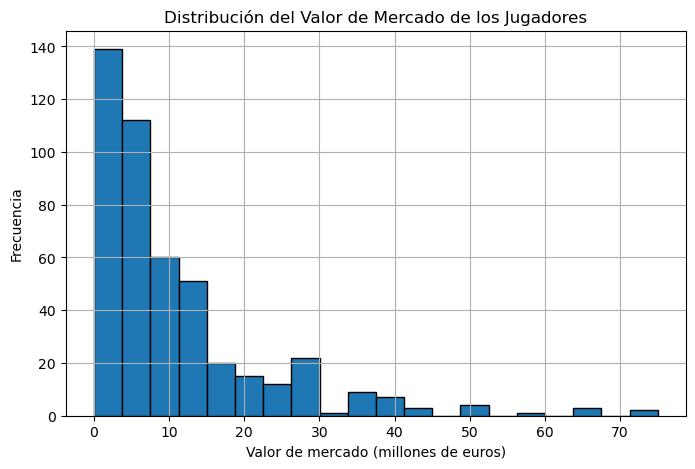

In [22]:
import matplotlib.pyplot as plt

# Convertir a Pandas
df_jugadores = jugadores_df.select("market_value").dropna().toPandas()

# Histograma
plt.figure(figsize=(8,5))
plt.hist(df_jugadores["market_value"], bins=20, edgecolor='black')
plt.title("Distribución del Valor de Mercado de los Jugadores")
plt.xlabel("Valor de mercado (millones de euros)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


### Distribución de Resultados de Partido (`FTR`)

La gráfica de barras se realizó para identificar la frecuencia de cada tipo de resultado. Es importante porque permite ver si existe una ventaja sistemática al jugar de local. Los resultados muestran justamente eso: la mayoría de partidos terminan con victoria del equipo local, mientras que empates y victorias visitantes son menos frecuentes. Esto aporta evidencia de la conocida ventaja de localía en la liga.


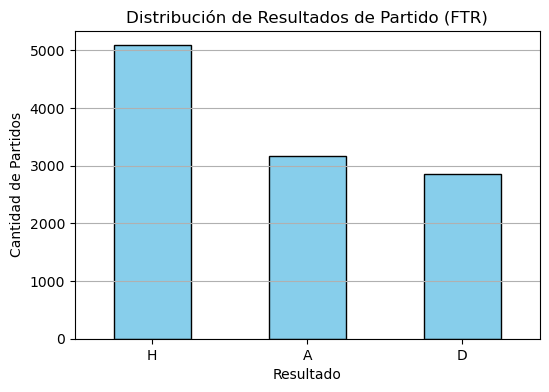

In [23]:
# Convertir a Pandas
df_resultados = resultados_df.select("FTR").dropna().toPandas()

# Conteo de categorías
plt.figure(figsize=(6,4))
df_resultados["FTR"].value_counts().plot(kind="bar", color="skyblue", edgecolor='black')
plt.title("Distribución de Resultados de Partido (FTR)")
plt.xlabel("Resultado")
plt.ylabel("Cantidad de Partidos")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


### Relación entre Tiros al Arco y Goles (`total_shots_on_target` vs. `total_goals`)

Se buscó comprobar si los equipos que generan más disparos al arco también convierten más goles. El gráfico de dispersión aporta claridad: existe una tendencia positiva, es decir, más tiros suelen asociarse con más goles. Sin embargo, también se ve que no todos los equipos son igual de efectivos, lo que ayuda a resaltar la importancia de la calidad de los remates, no solo la cantidad.


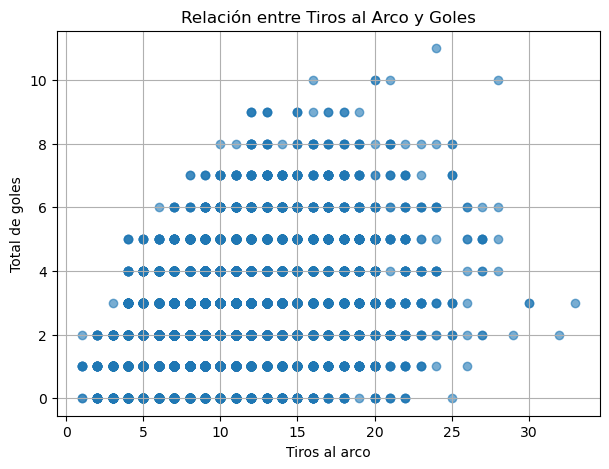

In [24]:
# Convertir a Pandas
df_resultados = resultados_df.select("total_shots_on_target", "total_goals").dropna().toPandas()

# Gráfico de dispersión
plt.figure(figsize=(7,5))
plt.scatter(df_resultados["total_shots_on_target"], df_resultados["total_goals"], alpha=0.6)
plt.title("Relación entre Tiros al Arco y Goles")
plt.xlabel("Tiros al arco")
plt.ylabel("Total de goles")
plt.grid(True)
plt.show()


### Relación entre Page Views y Puntos en Fantasy (`page_views` vs. `fpl_points`)

Esta visualización se hizo para ver si la popularidad de un jugador (medida en visitas a su perfil) está relacionada con su rendimiento en Fantasy Premier League. El aporte es interesante: algunos de los jugadores más vistos también son de los que más puntos suman, pero no siempre es así. Esto demuestra que la popularidad puede dar pistas, pero no garantiza un buen desempeño deportivo.


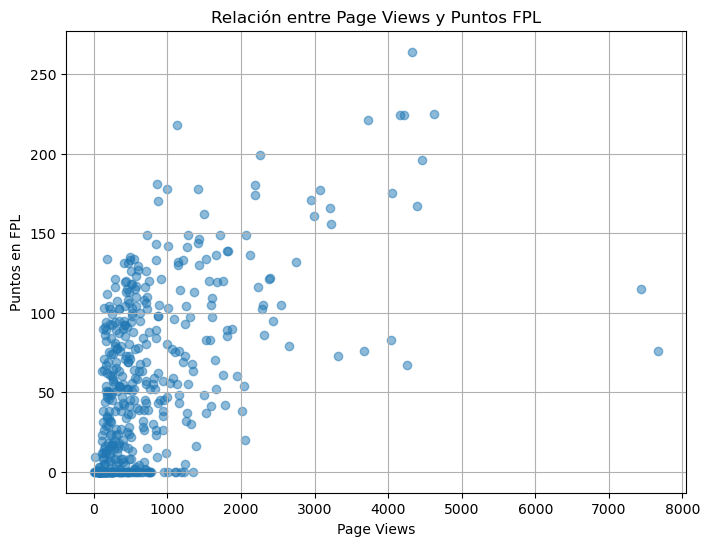

In [26]:
# Convertimos a pandas
jugadores_pd = jugadores_df.select("page_views", "fpl_points").dropna().toPandas()

# Gráfico
plt.figure(figsize=(8, 6))
plt.scatter(jugadores_pd["page_views"], jugadores_pd["fpl_points"], alpha=0.5)
plt.title("Relación entre Page Views y Puntos FPL")
plt.xlabel("Page Views")
plt.ylabel("Puntos en FPL")
plt.grid(True)
plt.show()


### Promedio de Goles por Tipo de Resultado (`FTR`)

El gráfico de promedios por resultado se generó para analizar si la cantidad de goles cambia según el desenlace del partido. Aporta un hallazgo sencillo pero útil: los partidos que terminan en victoria, tanto local como visitante, tienen más goles en promedio que los empates. Esto indica que los juegos más cerrados suelen derivar en pocos goles, mientras que los desequilibrados generan más anotaciones.


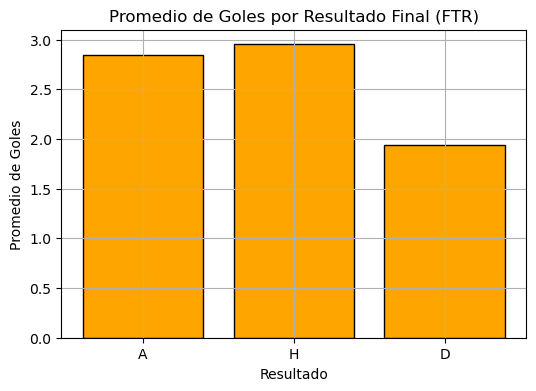

In [27]:
# Asegúrate de que la columna total_goals esté presente
from pyspark.sql.functions import col, avg

# Agrupar por FTR y calcular promedio de goles
promedios_df = resultados_df.groupBy("FTR").agg(avg("total_goals").alias("promedio_goles"))

# Convertimos a pandas
promedios_pd = promedios_df.toPandas()

# Gráfico
plt.figure(figsize=(6, 4))
plt.bar(promedios_pd["FTR"], promedios_pd["promedio_goles"], color="orange", edgecolor="black")
plt.title("Promedio de Goles por Resultado Final (FTR)")
plt.xlabel("Resultado")
plt.ylabel("Promedio de Goles")
plt.grid(True)
plt.show()


### Distribución de la Evaluación de Rendimiento (`player_rating`)

El gráfico fue creado para analizar cómo se distribuyen las calificaciones de desempeño otorgadas a los jugadores. Se identifican dos comportamientos claros: una gran cantidad de valores en **0**, que posiblemente corresponden a jugadores que no recibieron evaluación en ciertos partidos, y un segundo grupo concentrado entre **6 y 7 puntos**, indicando que la mayoría de los jugadores evaluados obtienen rendimientos moderados. Este análisis es útil para detectar tanto la **falta de evaluaciones** en muchos registros como la **tendencia general a calificaciones promedio**.


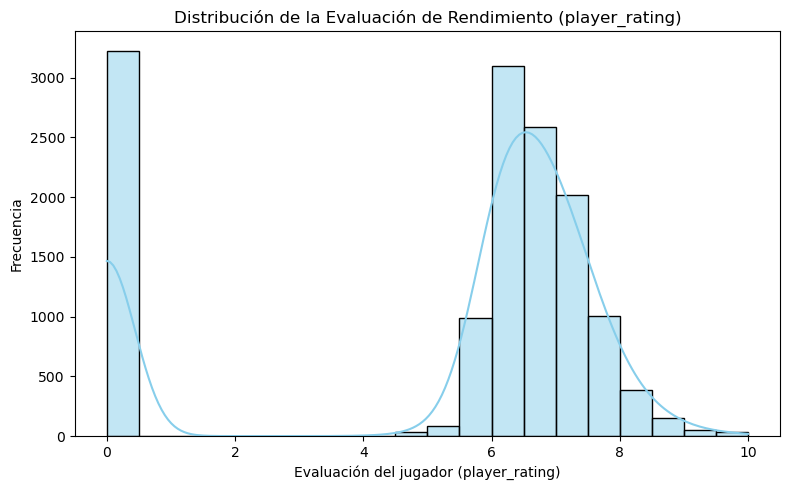

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la figura
plt.figure(figsize=(8, 5))

# Histograma con KDE (curva de densidad)
sns.histplot(df_temporadas["player_rating"], bins=20, kde=True, color='skyblue', edgecolor='black')

# Títulos y etiquetas
plt.title("Distribución de la Evaluación de Rendimiento (player_rating)")
plt.xlabel("Evaluación del jugador (player_rating)")
plt.ylabel("Frecuencia")
plt.tight_layout()

# Mostrar
plt.show()


### Top 10 Jugadores con más premios *Man of the Match*

El gráfico muestra los jugadores que más veces fueron reconocidos como *Man of the Match* durante la temporada, con **Harry Kane** y **Eden Hazard** liderando la tabla. Esta visualización permite identificar a los jugadores más determinantes dentro de sus equipos, aquellos que destacaron de manera consistente en los partidos.

En futuros análisis, podría resultar valioso **estudiar el estilo de juego de estos futbolistas** (posición, tipo de acciones destacadas, nivel de participación ofensiva o defensiva, etc.), para así **detectar patrones comunes y encontrar perfiles similares** que puedan ser considerados en procesos de scouting, fichajes o alineaciones estratégicas.


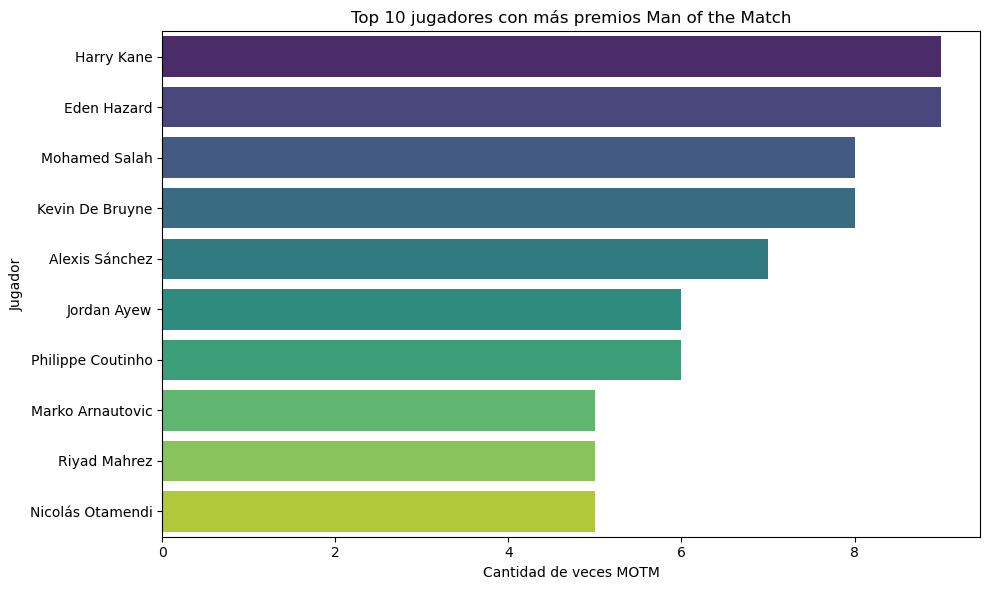

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo los jugadores que ganaron "Man of the Match"
motm_df = df_temporadas[df_temporadas["man_of_the_match"] == 1.0]

# Contar cuántas veces cada jugador fue MOTM
top_players = motm_df["player_name"].value_counts().head(10)

# Crear gráfico de barras horizontal (sin FutureWarning)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_players.values, y=top_players.index, hue=top_players.index, dodge=False, legend=False, palette="viridis")

# Títulos y etiquetas
plt.title("Top 10 jugadores con más premios Man of the Match")
plt.xlabel("Cantidad de veces MOTM")
plt.ylabel("Jugador")
plt.tight_layout()

# Mostrar gráfico
plt.show()


### Relación entre Pases Completados y Evaluación del Jugador (`passes_completed` vs `player_rating`)

Esta visualización permite observar si existe una relación entre la cantidad de pases completados por un jugador y su evaluación general de rendimiento. Aunque la nube de puntos muestra **una ligera tendencia positiva**, también evidencia que **no hay una correlación fuerte**: muchos jugadores con bajo número de pases aún obtienen buenas calificaciones, y viceversa.

Esto sugiere que **la evaluación global (`player_rating`) no depende únicamente del volumen de pases**, sino de un conjunto más amplio de acciones en el campo. En futuros análisis, podría ser útil segmentar por **posición** para verificar si esta relación es más fuerte entre mediocampistas, cuyo rol depende más del pase.


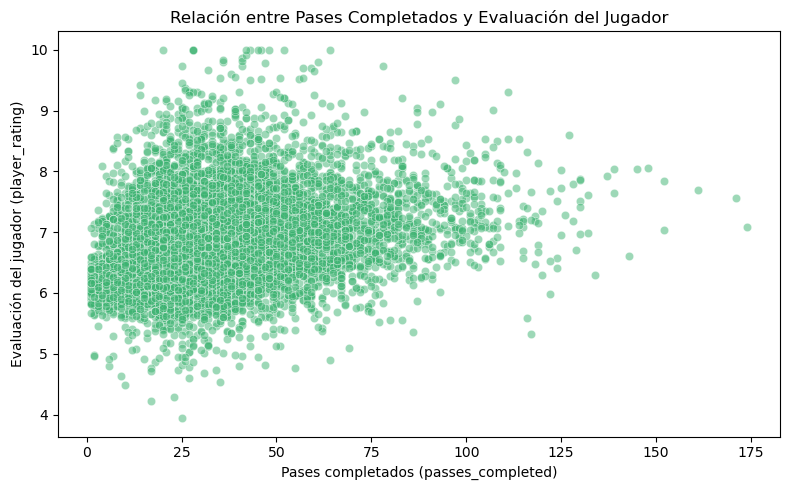

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la figura
plt.figure(figsize=(8, 5))

# Gráfico de dispersión simple
sns.scatterplot(
    data=df_temporadas,
    x="total_pass",
    y="player_rating",
    alpha=0.5,
    color="mediumseagreen"
)

# Títulos y etiquetas
plt.title("Relación entre Pases Completados y Evaluación del Jugador")
plt.xlabel("Pases completados (passes_completed)")
plt.ylabel("Evaluación del jugador (player_rating)")
plt.tight_layout()

# Mostrar gráfico
plt.show()


### Relación entre Goles Marcados y Evaluación del Jugador

Esta visualización muestra cómo varía la evaluación del jugador (`player_rating`) en función de la cantidad de goles marcados. Se observa una correlación positiva: quienes anotan más goles tienden a recibir una mejor calificación, muchas veces cercana a 10. Aunque el número de jugadores que marca 3 o más goles es reducido, sus valoraciones tienden a ser consistentemente altas. 


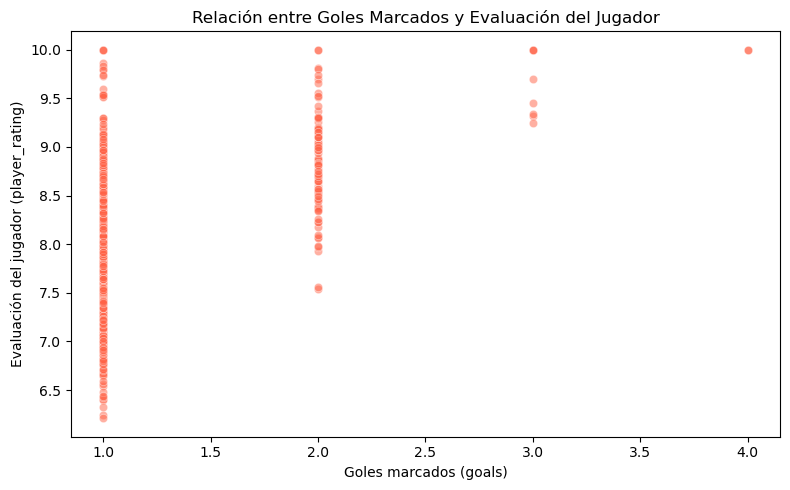

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la figura
plt.figure(figsize=(8, 5))

# Gráfico de dispersión: goals vs player_rating
sns.scatterplot(
    data=df_temporadas,
    x="goals",
    y="player_rating",
    alpha=0.5,
    color="tomato"
)

# Títulos y etiquetas
plt.title("Relación entre Goles Marcados y Evaluación del Jugador")
plt.xlabel("Goles marcados (goals)")
plt.ylabel("Evaluación del jugador (player_rating)")
plt.tight_layout()

# Mostrar
plt.show()


### Relación entre Entradas Realizadas y Evaluación del Jugador (`total_tackle` vs `player_rating`)

Este gráfico de dispersión muestra cómo varía la evaluación del jugador según la cantidad de entradas (tackles) realizadas durante un partido. Aunque no se observa una relación lineal clara, sí se puede notar que la mayoría de jugadores con evaluaciones altas realizaron entre 2 y 6 entradas. Sin embargo, valores muy altos no necesariamente se traducen en mejores evaluaciones.

Esto sugiere que las entradas no son un factor determinante en la calificación general de un jugador, ya que esta también depende de otros aspectos como pases, goles, posicionamiento, entre otros. 


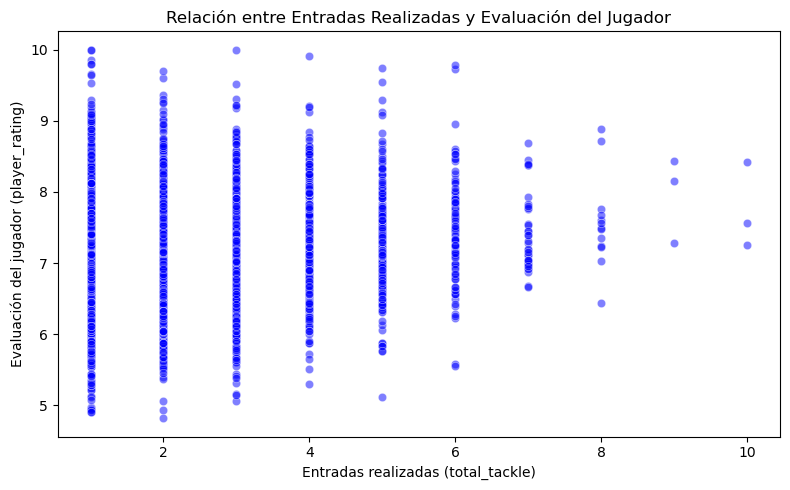

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la figura
plt.figure(figsize=(8, 5))

# Gráfico de dispersión simple
sns.scatterplot(
    data=df_temporadas,
    x="total_tackle",
    y="player_rating",
    alpha=0.5,
    color="blue"
)

# Títulos y etiquetas
plt.title("Relación entre Entradas Realizadas y Evaluación del Jugador")
plt.xlabel("Entradas realizadas (total_tackle)")
plt.ylabel("Evaluación del jugador (player_rating)")
plt.tight_layout()

# Mostrar gráfico
plt.show()


### Relación entre Evaluaciones Altas (>7) y Premios Man of the Match

El gráfico de pastel ilustra que el 100% de los jugadores con una evaluación superior a 7 (`player_rating`) también fueron premiados como Man of the Match (`MOTM`). Este hallazgo sugiere una correspondencia total entre una calificación alta y el reconocimiento como el mejor del partido. 


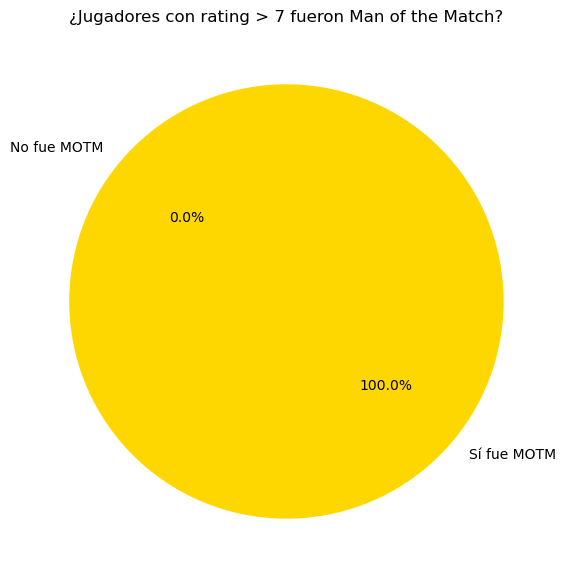

In [41]:
import matplotlib.pyplot as plt

# Filtrar jugadores con player_rating > 7
jugadores_destacados = df_temporadas[df_temporadas["player_rating"] > 7]

# Calcular cuántos de esos fueron man_of_the_match
motm_conteo = jugadores_destacados["man_of_the_match"].value_counts().to_dict()

# Etiquetas legibles
etiquetas = {
    1.0: "Sí fue MOTM",
    0.0: "No fue MOTM"
}

# Reordenar para asegurar que ambas categorías estén
conteo_final = {
    "Sí fue MOTM": motm_conteo.get(1.0, 0),
    "No fue MOTM": motm_conteo.get(0.0, 0)
}

# Gráfico de torta
plt.figure(figsize=(6, 6))
plt.pie(conteo_final.values(), labels=conteo_final.keys(), autopct="%1.1f%%", startangle=140, colors=["gold", "lightgrey"])
plt.title("¿Jugadores con rating > 7 fueron Man of the Match?")
plt.tight_layout()
plt.show()


## 7. Hallazgos especiales / correlaciones

El análisis de las variables clave y sus visualizaciones permitió identificar algunos hallazgos que resultan útiles para entender tanto el rendimiento deportivo como los factores económicos y de popularidad en la liga:

- **Concentración de valor de mercado:** La mayoría de jugadores tienen un valor relativamente bajo, mientras que solo unos pocos alcanzan cifras muy altas. Esto indica que, al momento de construir un nuevo equipo, es más realista enfocarse en talento emergente de bajo costo, reservando las grandes inversiones para fichajes muy puntuales.

- **Ventaja de jugar en casa:** Los equipos locales ganan con mucha más frecuencia que los visitantes. Esto sugiere que cualquier análisis de estrategia debe tener en cuenta la condición de localía, ya que jugar en casa no solo aumenta la probabilidad de victoria, sino que también está asociado con un mayor promedio de goles.

- **Relación entre tiros y goles:** Existe una correlación clara entre la cantidad de disparos al arco y los goles marcados. Esto refuerza la importancia de generar ocasiones de ataque, aunque también quedó en evidencia que no todos los equipos son igual de efectivos, lo que abre espacio para valorar la calidad de los remates y no solo la cantidad.

- **Popularidad vs. rendimiento:** Algunos de los jugadores con más visitas en línea también destacan por su rendimiento en Fantasy Premier League, pero no todos. Esto demuestra que la popularidad puede ser un buen indicador para atraer audiencia y marketing, aunque no garantiza siempre el mejor desempeño deportivo.

- **Empates con menos goles:** Los partidos que terminan empatados suelen registrar menos goles que aquellos con victorias. Esto sugiere que los encuentros más disputados y cerrados tienden a ser más defensivos, mientras que las victorias (sobre todo de local) se acompañan de una ofensiva más fuerte.

- **Evaluaciones infladas por goles o pases:** Tanto los goles como los pases completados tienen relación con un mayor `player_rating`, pero en diferentes niveles. Los goles tienden a elevar la calificación a niveles muy altos (por encima de 9), mientras que los pases, aunque útiles, tienen un efecto más suave. Esto puede reflejar cómo el sistema de evaluación valora de forma diferenciada los aportes ofensivos.

- **Reconocimiento del rendimiento con premios MOTM:** Todos los jugadores con calificación mayor a 7 fueron premiados como Man of the Match. Esto sugiere que el sistema de reconocimiento está alineado con el rendimiento medido cuantitativamente. Sin embargo, es importante notar que una calificación de 7, aunque buena, no necesariamente indica un desempeño sobresaliente. Por lo tanto, podrían estar reconociéndose actuaciones sólidas pero no excepcionales.

- **Jugadores determinantes identificables:** Al observar los jugadores con más premios MOTM, se pueden detectar figuras clave que marcan la diferencia en sus equipos. Este tipo de análisis podría complementarse en el futuro con el estudio de su estilo de juego para buscar perfiles similares en el mercado de fichajes.

- **Impacto limitado de las entradas defensivas:** El análisis de la relación entre entradas realizadas y evaluación del jugador muestra que, aunque un número moderado de entradas puede coincidir con buenas calificaciones, no existe una relación directa y consistente. Esto indica que las entradas no son el único factor relevante en la evaluación, y que el desempeño defensivo puede tener un peso menor en la calificación final del jugador en comparación con acciones ofensivas.



En conjunto, estos hallazgos permiten entender mejor la dinámica de la liga y aportan información útil para tomar decisiones estratégicas en la conformación de equipos, desde el scouting de jugadores hasta la planificación de estilos de juego.


## 8. Conclusiones y recomendaciones

1. **Enfoque en jugadores costo-beneficio:** Aprovechar el gran número de futbolistas de bajo costo para construir la base del equipo, priorizando fichajes de alto valor únicamente en posiciones estratégicas.

2. **Refuerzo de la ofensiva en casa:** Diseñar estrategias que potencien el ataque cuando se juega de local, aprovechando la ventaja demostrada en los datos.

3. **Entrenamiento en definición:** No solo buscar volumen de disparos, sino trabajar en mejorar la precisión y efectividad de los remates para optimizar la relación entre tiros y goles.

4. **Balance entre marketing y rendimiento:** Considerar la popularidad como un factor adicional en fichajes, útil para aumentar ingresos y visibilidad, pero sin perder de vista el rendimiento real de los jugadores.

5. **Preparación para partidos cerrados:** Desarrollar planes específicos para enfrentamientos que se anticipen como defensivos, buscando romper la tendencia de empates con baja producción ofensiva.

6. **Monitoreo de jugadores consistentes:** Aquellos con altos ratings suelen ser reconocidos con premios individuales, por lo que vale la pena identificar y seguir jugadores que mantengan una evaluación estable por encima de 7.

7. **Análisis de perfiles tipo MOTM:** Estudiar en más detalle las características comunes (posición, estilo de juego, estadísticas clave) de los jugadores que más veces fueron Man of the Match, como Harry Kane o Salah, para orientar fichajes hacia perfiles similares.

8. **Revisión de criterios de evaluación:** Se evidenció que la cantidad de entradas defensivas no tiene una correlación tan fuerte con las evaluaciones altas como otras acciones más ofensivas. Esto podría generar un sesgo en los sistemas de calificación que priorizan la ofensiva sobre la defensa. Se recomienda considerar este desequilibrio al momento de valorar el rendimiento de jugadores defensivos o de contención.


9. **Cautela con métricas absolutas:** A pesar de que jugadores con calificaciones superiores a 7 fueron premiados, este valor no necesariamente implica excelencia. Se recomienda usar escalas más exigentes o combinaciones de variables para distinguir actuaciones verdaderamente excepcionales.

